# Importing Modules

In [1]:
!pip install 'eTaPR-21.8.2-py3-none-any.whl'

import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

Processing ./eTaPR-21.8.2-py3-none-any.whl


# Load Data

In [3]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [4]:
TRAIN_DATASET = sorted([x for x in Path("train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("test/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("validation/").glob("*.csv")])

TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)
print(TRAIN_DF_RAW.shape)
TRAIN_DF_RAW.head()

(1004402, 87)


,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,50,11704,17.61017,28.03686,27170,27.24188,25.42843,0,1,50,27.28778,31.02721,1,267.90363,467.27020,3865,50,14742,0.88504,1,54816,1009.15302,58.21227,5.5352,0,126.92957,2880,26.92264,0,0,...,48.64655,1,0,13752,41.81518,1,0.14465,0.46783,0,276.45758,476.76703,8.90254,49.26452,719.96625,1,923,0,0,16,0.08771,15.07713,9914,1,306.07104,28.20367,15.50464,251.23593,451.06253,26.13983,48.90190,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,50,11847,17.61780,28.03169,27171,27.24188,25.42656,0,1,50,27.28778,31.01196,1,268.95258,466.91238,3898,50,14781,0.88619,1,54816,1011.06647,57.44932,4.7507,0,126.92957,2880,26.92264,0,0,...,50.40893,1,0,13752,41.81518,1,0.14465,0.42892,0,278.91705,476.76703,8.90254,49.26452,720.10663,1,923,0,0,16,0.08771,14.97197,9914,1,303.09189,28.19449,16.20023,250.47298,404.38739,26.13983,48.94870,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,50,11953,17.61780,28.03504,27170,27.24188,25.41979,0,1,50,27.28778,31.01196,1,269.76636,466.91238,3892,50,14831,0.88836,1,54816,1009.79083,58.78445,5.5709,0,126.92957,2880,26.92264,0,0,...,50.60730,1,0,13760,41.81518,1,0.14465,0.42282,0,278.89899,476.76703,8.90254,49.26452,719.96625,1,923,0,0,16,0.08771,14.90129,9914,1,299.11945,28.18530,16.53352,249.90080,382.53925,26.14746,48.89090,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,50,12051,17.61780,28.03510,27171,27.24188,25.44255,0,1,50,27.28778,31.01196,1,271.64716,466.35010,3876,50,14917,0.89214,1,54816,1008.77380,59.16594,5.1828,0,126.92957,2880,26.92264,0,0,...,49.14246,1,0,13760,41.81518,1,0.14465,0.43121,0,280.49048,476.76703,8.90254,49.26452,720.00159,1,923,0,0,16,0.08771,14.82246,9914,1,306.07104,28.17612,16.30247,250.47298,396.44250,26.13983,48.95938,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,50,12180,17.61780,28.03510,27171,27.24188,25.44007,0,1,50,27.28778,31.02721,1,272.80457,466.60565,3871,50,14997,0.89191,1,54815,1009.79083,58.78445,5.1828,0,126.92957,2880,26.92264,0,0,...,47.18170,1,0,13760,41.81518,1,0.14465,0.45486,0,283.47437,476.76703,8.90254,49.26452,720.00159,1,923,0,0,16,0.08771,14.73087,9914,1,308.05728,28.16693,15.79237,250.28227,427.22849,26.13983,49.02211,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503


In [5]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [6]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [7]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [8]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,0.390156,0.501876,0.520480,0.449040,0.252360,0.193673,0.0,0.0,0.0,0.305026,0.452537,0.0,0.133292,0.578120,0.626384,0.0,0.135313,0.132221,0.0,0.976296,0.513118,0.259863,0.369939,0.0,0.900937,0.0,0.209725,0.0,0.0,0.029799,...,0.424797,1.0,0.0,0.994220,0.471624,0.0,0.000575,0.130348,0.0,0.172978,0.798452,0.178051,0.241962,0.465834,1.0,0.909722,0.0,0.0,0.007323,0.22613,0.150771,0.207547,0.0,0.321628,0.805819,0.155046,0.443864,0.138395,0.191217,0.246855,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,0.397402,0.502077,0.403097,0.450383,0.252360,0.193649,0.0,0.0,0.0,0.305026,0.450531,0.0,0.136943,0.576120,0.631199,0.0,0.137850,0.133443,0.0,0.976296,0.519266,0.256744,0.245047,0.0,0.900937,0.0,0.209725,0.0,0.0,0.028294,...,0.443542,1.0,0.0,0.994220,0.471624,0.0,0.000575,0.101569,0.0,0.181368,0.798452,0.178051,0.241962,0.596204,1.0,0.909722,0.0,0.0,0.007323,0.22613,0.149815,0.207547,0.0,0.318762,0.805581,0.161370,0.439117,0.125047,0.191217,0.248731,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,0.403379,0.502095,0.467897,0.449173,0.252360,0.193558,0.0,0.0,0.0,0.305026,0.450351,0.0,0.140079,0.575940,0.630765,0.0,0.141302,0.135839,0.0,0.976296,0.515758,0.261871,0.363195,0.0,0.900937,0.0,0.209725,0.0,0.0,0.029108,...,0.447321,1.0,0.0,0.994740,0.471624,0.0,0.000575,0.094505,0.0,0.182062,0.798452,0.178051,0.241962,0.478753,1.0,0.909722,0.0,0.0,0.007323,0.22613,0.149092,0.207547,0.0,0.314716,0.805323,0.164942,0.435161,0.117652,0.191315,0.246604,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,0.408887,0.502096,0.475662,0.450383,0.252360,0.193846,0.0,0.0,0.0,0.305026,0.450333,0.0,0.146871,0.572809,0.628411,0.0,0.147183,0.140053,0.0,0.976296,0.512176,0.263923,0.313719,0.0,0.900937,0.0,0.209725,0.0,0.0,0.031288,...,0.432270,1.0,0.0,0.994792,0.471624,0.0,0.000575,0.099950,0.0,0.187506,0.798452,0.178051,0.241962,0.499620,1.0,0.909722,0.0,0.0,0.007323,0.22613,0.148311,0.207547,0.0,0.320938,0.805061,0.163216,0.438294,0.120857,0.191227,0.249111,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,0.415910,0.502097,0.476437,0.450504,0.252360,0.193843,0.0,0.0,0.0,0.305026,0.452317,0.0,0.151538,0.573911,0.627454,0.0,0.152922,0.140232,0.0,0.974963,0.515053,0.262584,0.308776,0.0,0.900937,0.0,0.209725,0.0,0.0,0.033876,...,0.410120,1.0,0.0,0.994797,0.471624,0.0,0.000575,0.117812,0.0,0.198128,0.798452,0.178051,0.241962,0.501704,1.0,0.909722,0.0,0.0,0.007323,0.22613,0.147409,0.207547,0.0,0.323451,0.804799,0.158453,0.437432,0.129893,0.191218,0.251851,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004397,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,0.213613,0.381810,0.459083,0.511453,0.371984,0.370597,0.0,0.0,0.0,0.752517,0.507725,0.0,0.326726,0.565976,0.006420,0.0,0.318660,0.368856,0.0,0.863704,0.452023,0.262573,0.404346,0.0,0.413326,0.0,0.748145,0.0,0.0,0.976893,...,0.000714,1.0,0.0,0.000578,0.124171,0.0,0.6825

In [9]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [10]:
boundary_check(TRAIN_DF)

(False, False, False)

In [11]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        
        return item

In [12]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
HAI_DATASET_TRAIN[0]

  0%|          | 0/1004313 [00:00<?, ?it/s]

# of valid windows: 1003868


{'answer': tensor([0.3711, 0.0000, 0.0563, 0.5032, 0.1387, 0.4298, 0.8161, 0.0000, 0.0000,
         0.0000, 0.7223, 0.6224, 0.4866, 0.4075, 0.2524, 0.2907, 0.0000, 0.0000,
         0.0000, 0.3050, 0.4108, 0.0000, 0.3492, 0.6516, 0.0120, 0.0000, 0.3563,
         0.3370, 0.0000, 0.9763, 0.5501, 0.3796, 0.3818, 0.0000, 0.9009, 0.0000,
         0.2097, 0.0000, 0.0000, 0.0249, 0.2642, 0.5416, 0.5994, 0.4009, 0.0021,
         1.0000, 0.5253, 1.0000, 0.0000, 0.2244, 0.4755, 0.0000, 0.4874, 0.0509,
         0.0000, 0.3105, 0.7985, 0.1781, 0.2572, 0.4340, 1.0000, 0.9166, 0.0000,
         0.0000, 0.5312, 0.2261, 0.1222, 0.2123, 0.0000, 0.4706, 0.7825, 0.1565,
         0.4803, 0.1081, 0.2816, 0.2517, 0.2480, 0.2531, 0.7088, 0.1132, 0.5313,
         0.0000, 0.5381, 0.0000, 0.0000, 0.0091]),
 'given': tensor([[0.4331, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2761],
         [0.3951, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2752],
         [0.3333, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2749],
      

In [13]:
print(HAI_DATASET_TRAIN[0]['given'].shape)
print(HAI_DATASET_TRAIN[0]['answer'].shape)

torch.Size([89, 86])
torch.Size([86])


# Building a Model

- 모델은 데이콘에서 제공한 StackedGRU가 아닌 Transformer 모델을 사용함
- input sequence가 길 경우 기존 GRU에 비해 상대적으로 학습에 효율적이며 self-attention을 사용해 한번에 전체 맥락 파악
- Transforme는 DARNN 구조와 같이 encoder에서는 feature attention을 사용하여 context vector 생성
- TimeDistributed를 사용하여 시계열 단위에 layer를 적용해 독립된 Linear를 사용


## Reference

1. [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) - Paper
2. [A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction](https://arxiv.org/abs/1704.02971) - Paper

In [14]:
import easydict
import math
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
def get_sinusoid_encoding_table(n_seq, hidn):

    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / hidn)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table


def get_attn_decoder_mask(seq):
    batch, window_size, d_hidn = seq.size()
    subsequent_mask = torch.ones((batch,window_size,window_size), device=seq.device)
    subsequent_mask = subsequent_mask.triu(diagonal=1)
    return subsequent_mask


class scaleddotproductattention(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.dropout = nn.Dropout(self.args.dropout)
        self.scale = 1 / (self.args.d_head ** 0.5)

    def forward(self, q, k, v, attn_mask=False):
        scores = torch.matmul(q, k.transpose(-1, -2))
        scores = scores.mul_(self.scale)

        if attn_mask is not False:
            scores.masked_fill_(attn_mask, -1e9)
            attn_prob = nn.Softmax(dim=-1)(scores)
            attn_prob = self.dropout(attn_prob)
            context = torch.matmul(attn_prob, v)
        else:
            attn_prob = nn.Softmax(dim=-1)(scores)
            attn_prob = self.dropout(attn_prob)
            context = torch.matmul(attn_prob, v)

        return context, attn_prob


class multiheadattention(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.W_Q = nn.Linear(self.args.d_hidn, self.args.n_head * self.args.d_head)
        self.W_K = nn.Linear(self.args.d_hidn, self.args.n_head * self.args.d_head)
        self.W_V = nn.Linear(self.args.d_hidn, self.args.n_head * self.args.d_head)
        self.scaled_dot_attn = scaleddotproductattention(self.args)
        self.linear = nn.Linear(self.args.n_head * self.args.d_head, self.args.d_hidn)
        self.dropout = nn.Dropout(self.args.dropout)

    def forward(self, q, k, v, attn_mask=False):
        batch_size = q.size(0)
        q_s = self.W_Q(q).view(batch_size, -1, self.args.n_head, self.args.d_head).transpose(1,2)
        k_s = self.W_K(k).view(batch_size, -1, self.args.n_head, self.args.d_head).transpose(1,2)
        v_s = self.W_V(v).view(batch_size, -1, self.args.n_head, self.args.d_head).transpose(1,2)

        if attn_mask is not False:
            attn_mask = attn_mask.unsqueeze(1).repeat(1, self.args.n_head, 1, 1)
            context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        else:
            context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.args.n_head * self.args.d_head)

        output = self.linear(context)
        output = self.dropout(output)

        return output, attn_prob


class poswisefeedforwardnet(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.conv1 = nn.Conv1d(in_channels=self.args.d_hidn, out_channels=self.args.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.args.d_ff, out_channels=self.args.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(self.args.dropout)

    def forward(self, inputs):
        output = self.conv1(inputs.transpose(1, 2).contiguous())
        output = self.active(output)
        output = self.conv2(output).transpose(1, 2).contiguous()
        output = self.dropout(output)

        return output


class encoderlayer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.self_attn = multiheadattention(self.args)
        self.pos_ffn = poswisefeedforwardnet(self.args)

    def forward(self, inputs):
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs)
        att_outputs = att_outputs + inputs

        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = ffn_outputs + att_outputs

        return ffn_outputs, attn_prob


class encoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.enc_emb = nn.Linear(in_features=self.args.window_size, out_features=self.args.d_hidn, bias=False)
        nusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.args.e_features , self.args.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(nusoid_table, freeze=True)
        self.layers = nn.ModuleList([encoderlayer(self.args) for _ in range(self.args.n_layer)])
        self.enc_attn_probs = None

    def forward(self, inputs):
        self.enc_attn_probs = []
        positions = torch.arange(inputs.size(2), device=inputs.device).expand(inputs.size(0), inputs.size(2)).contiguous()
        outputs = self.enc_emb(inputs.transpose(2,1).contiguous()) + self.pos_emb(positions)

        for layer in self.layers:
            outputs, enc_attn_prob = layer(outputs)
            self.enc_attn_probs.append(enc_attn_prob)

        return outputs

class decoderlayer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.self_attn = multiheadattention(self.args)
        self.dec_enc_attn = multiheadattention(self.args)
        self.pos_ffn = poswisefeedforwardnet(self.args)

    def forward(self, dec_inputs, enc_outputs, attn_mask):
        self_att_outputs, dec_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, attn_mask)
        self_att_outputs = self_att_outputs + dec_inputs

        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs)
        dec_enc_att_outputs = dec_enc_att_outputs + self_att_outputs

        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = ffn_outputs + dec_enc_att_outputs

        return ffn_outputs, dec_attn_prob, dec_enc_attn_prob


class decoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.dec_emb = nn.Linear(in_features=self.args.d_features, out_features=self.args.d_hidn, bias=False)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.args.window_size , self.args.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)
        self.layers = nn.ModuleList([decoderlayer(self.args) for _ in range(self.args.n_layer)])
        self.dec_attn_probs = None
        self.dec_enc_attn_probs = None

    def forward(self, dec_inputs, enc_outputs):
        self.dec_attn_probs = []
        self.dec_enc_attn_probs = []
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous()
        dec_output = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        attn_mask = torch.gt(get_attn_decoder_mask(dec_inputs),0)

        for layer in self.layers:
            dec_outputs, dec_attn_prob, dec_enc_attn_prob = layer(dec_output, enc_outputs, attn_mask)
            self.dec_attn_probs.append(dec_attn_prob)
            self.dec_enc_attn_probs.append(dec_enc_attn_prob)

        return dec_outputs


class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        y = self.module(x_reshape)

        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y


class transformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.encoder = encoder(self.args)
        self.decoder = decoder(self.args)
        self.fc1 = TimeDistributed(nn.Linear(in_features=self.args.window_size*self.args.d_hidn, out_features=self.args.dense_h))
        self.fc2 = TimeDistributed(nn.Linear(in_features=self.args.dense_h, out_features=self.args.output_size))

    def forward(self, enc_inputs, dec_inputs):
        enc_outputs = self.encoder(enc_inputs)
        dec_outputs = self.decoder(dec_inputs, enc_outputs)

        dec_outputs = self.fc1(dec_outputs.view(dec_outputs.size(0),-1))
        dec_outputs = self.fc2(dec_outputs)

        return dec_outputs

In [16]:
args = easydict.EasyDict({
                        'output_size' : 86,
                        'window_size' : 89,
                        'batch_size' : 1024,
                        'lr' : 1e-3,
                        'e_features' : 86,
                        'd_features' : 86,
                        'd_hidn' : 128,
                        'n_head' : 4,
                        'd_head' : 32,
                        'dropout' : 0.1,
                        'd_ff' : 128,
                        'n_layer' : 3,
                        'dense_h' : 128,
                        'epochs' : 10,
                        'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
                        'save_path' : '/SAVE/'
                        })

In [ ]:
model = transformer(args).to(args.device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
dataloader = DataLoader(HAI_DATASET_TRAIN, batch_size=args.batch_size, shuffle=True)

In [ ]:
loss_list = []

for epoch in tqdm(range(1, args.epochs+1)):
    total_loss = 0
    n =0

    for data in dataloader:
        input_data = data['given']
        target = data['answer']
        model.train()
        optimizer.zero_grad()
        pred = model(input_data.to(args.device), input_data.to(args.device))
        loss = loss_function(pred, target.to(args.device))
        loss.backward()
        optimizer.step()
        total_loss += (loss*input_data.size()[0])
        n += input_data.size()[0]

    loss_list.append(total_loss/n)

    print('epoch: {}, Train MSE_loss : {:.5f}'.format(epoch, total_loss/n))

 10%|█         | 1/10 [12:37<1:53:39, 757.75s/it]

epoch: 1, Train MSE_loss : 0.05542


 20%|██        | 2/10 [25:16<1:41:08, 758.55s/it]

epoch: 2, Train MSE_loss : 0.00317


 30%|███       | 3/10 [37:56<1:28:32, 759.00s/it]

epoch: 3, Train MSE_loss : 0.00220


 40%|████      | 4/10 [50:35<1:15:54, 759.08s/it]

epoch: 4, Train MSE_loss : 0.00174


 50%|█████     | 5/10 [1:03:15<1:03:17, 759.48s/it]

epoch: 5, Train MSE_loss : 0.00136


 60%|██████    | 6/10 [1:15:57<50:40, 760.15s/it]  

epoch: 6, Train MSE_loss : 0.00101


 70%|███████   | 7/10 [1:28:38<38:01, 760.47s/it]

epoch: 7, Train MSE_loss : 0.00081


 80%|████████  | 8/10 [1:41:18<25:20, 760.45s/it]

epoch: 8, Train MSE_loss : 0.00065


 90%|█████████ | 9/10 [1:53:57<12:39, 759.82s/it]

epoch: 9, Train MSE_loss : 0.00054


100%|██████████| 10/10 [2:06:34<00:00, 759.47s/it]

epoch: 10, Train MSE_loss : 0.00046


In [ ]:
# 모델 저장
torch.save(model.state_dict(), 'transfomer_10')

In [17]:
# 모델 생성
model = transformer(args).to(args.device)

# 저장된 model 불러오기
with open('transfomer_10', "rb") as f:
     saved_state_dict = torch.load(f)
model.load_state_dict(saved_state_dict)

<All keys matched successfully>

# evaluation

In [18]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,50,10289,11.68213,28.03510,27181,27.84305,29.50472,0,1,50,27.796206,31.04248,1,334.58112,437.98016,3,50,18131,1.04366,1,54830,1032.43347,57.25861,4.9870,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,71.77734,0.44952,0,292.86029,431.328095,20.989594,51.26343,720.02826,1,927,0,0,15184,0.059445,14.91310,10000,1,300.11276,35.00000,15.09755,264.01520,438.15259,30.90057,50.63332,1.22543,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,50,10266,11.68213,28.03419,27174,27.84305,29.41619,0,1,50,27.796206,31.04248,1,332.97162,437.62238,2,50,18111,1.04217,1,54829,1032.43347,57.06784,5.3008,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,74.29114,0.44723,0,295.82605,431.328095,20.989594,51.26343,719.85382,1,926,0,0,14224,0.059445,14.95540,9999,1,298.12650,35.00000,14.71477,264.01520,465.95908,30.88531,50.64244,1.22543,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,50,10238,11.68213,28.03429,27172,27.84305,29.31749,0,1,50,27.796206,31.04248,1,332.15784,437.11121,2,50,18100,1.03920,1,54828,1031.79565,56.68636,4.5175,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,70.54761,0.43884,0,300.02173,431.328095,20.989594,51.26343,719.92407,1,927,0,0,12368,0.059445,14.99200,9999,1,297.13321,35.00000,14.30731,263.63373,452.05582,30.58014,50.65156,1.21475,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,50,10215,11.68213,28.03686,27168,27.84305,29.26632,0,1,50,27.796206,31.04248,1,330.96429,437.16232,2,50,18000,1.03222,1,54829,1033.07117,56.68636,5.4640,0,129.60573,2880,27.736847,0,0,...,1,0,8,45.33997,1,59.44373,0.42435,0,302.10144,431.328095,20.989594,51.26343,720.02954,1,924,0,0,11888,0.059445,15.01359,9999,1,295.14697,35.00000,14.54943,264.39661,434.18011,30.06897,50.68747,1.20255,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,50,10085,11.68213,28.02990,27172,27.84305,29.20597,0,1,50,27.796206,31.04248,1,329.02917,437.11121,2,50,17852,1.02947,1,54830,1031.47668,55.73270,4.5850,0,129.60573,2880,27.736847,0,0,...,1,0,688,45.33997,1,57.27356,0.40451,0,305.03113,431.328095,20.989594,51.14899,720.02905,1,927,0,0,10688,0.059445,15.04767,9999,1,295.14697,35.00000,15.24461,263.44296,411.33905,30.05371,50.64556,1.20483,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,50,6494,14.42108,28.02736,27265,27.86172,37.79226,0,1,50,27.796206,31.98853,1,354.96240,455.76889,3,50,19244,1.24152,1,54727,1021.90936,70.03782,5.2654,0,109.91794,2880,27.804180,0,0,...,1,0,8,39.84681,1,0.56064,1.38260,0,347.45734,451.941960,20.989594,50.21057,720.00098,1,905,0,0,16,0.193330,35.65305,10022,1,360.69107,25.53188,15.29280,257.72092,1179.76929,38.01117,49.54745,1.25824,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,50,6496,14.41345,28.03598,27262,27.86

In [19]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [20]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [21]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]

  0%|          | 0/86311 [00:00<?, ?it/s]

# of valid windows: 86311


{'answer': tensor([ 3.3894e-01,  0.0000e+00, -4.0688e-02,  5.5241e-01,  1.4881e-01,
          4.1252e-01,  1.1192e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.0504e-01,  5.4733e-01,  4.3329e-01,  5.1462e-01,  3.9176e-01,
          2.2703e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.4392e-01,
          5.1435e-01,  0.0000e+00,  4.3473e-01,  2.6757e-01,  1.0783e-01,
          0.0000e+00,  4.3937e-01,  3.6840e-01,  0.0000e+00,  9.9556e-01,
          5.8627e-01,  2.9203e-01,  2.2335e-01,  0.0000e+00,  9.9090e-01,
          0.0000e+00,  3.0786e-01,  0.0000e+00,  0.0000e+00,  4.6977e-02,
          1.3655e-01,  5.2711e-01,  5.6049e-01,  3.3544e-01,  9.9918e-01,
          1.0000e+00,  3.6266e-01,  1.0000e+00,  0.0000e+00,  3.9487e-01,
          6.9286e-01,  0.0000e+00,  5.7535e-04,  2.1527e-01,  0.0000e+00,
          4.3387e-01,  3.6955e-01,  4.1979e-01,  3.7024e-01,  4.2942e-01,
          1.0000e+00,  9.3000e-01,  0.0000e+00,  0.0000e+00,  3.2547e-03,
          3.0846e-02,  1.570

In [22]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given, given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [23]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, model, args.batch_size)

CPU times: user 34.3 s, sys: 94.4 ms, total: 34.4 s
Wall time: 34.5 s


- range_check func은 이상치를 더 크게 표현하고 이상치가 아닌 경우 더 작게 표현하기 위한 장치

In [36]:
def range_check(series, size):
    data = []
    
    for i in range(size, len(series)+1):
        if i == size :
            check_std = np.std(series[i-size:i])
        std = np.std(series[i-size:i])
        mean = np.mean(series[i-size:i])
        max = np.max(series[i-size:i])
        check_std
        if check_std * 2 >= std:
            check_std = std
            data.append(mean)
        elif max == series[i]:
            data.append(max*5)
            check_std = std
        else:
            data.append(series[i]*3)
    for _ in range(size-1):
        data.append(mean)

    return np.array(data)

In [37]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
C_ANOMALY_SCORE = range_check(ANOMALY_SCORE, size=30)
print(C_ANOMALY_SCORE.shape)

(86311,)


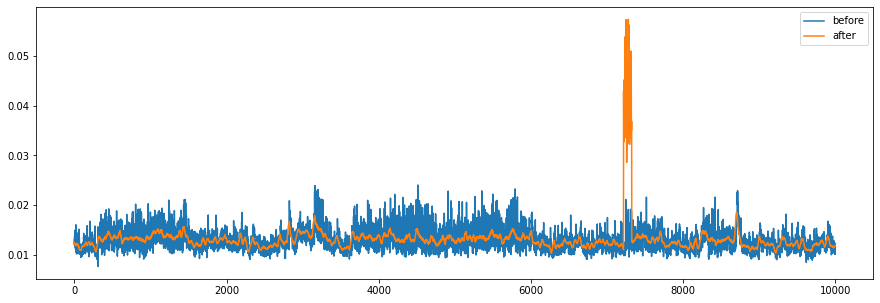

In [38]:
plt.figure(figsize=(15,5))
plt.plot(ANOMALY_SCORE[10000:20000], label='before')
plt.plot(C_ANOMALY_SCORE[10000:20000], label='after')
plt.legend()
plt.show()

In [39]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = np.max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

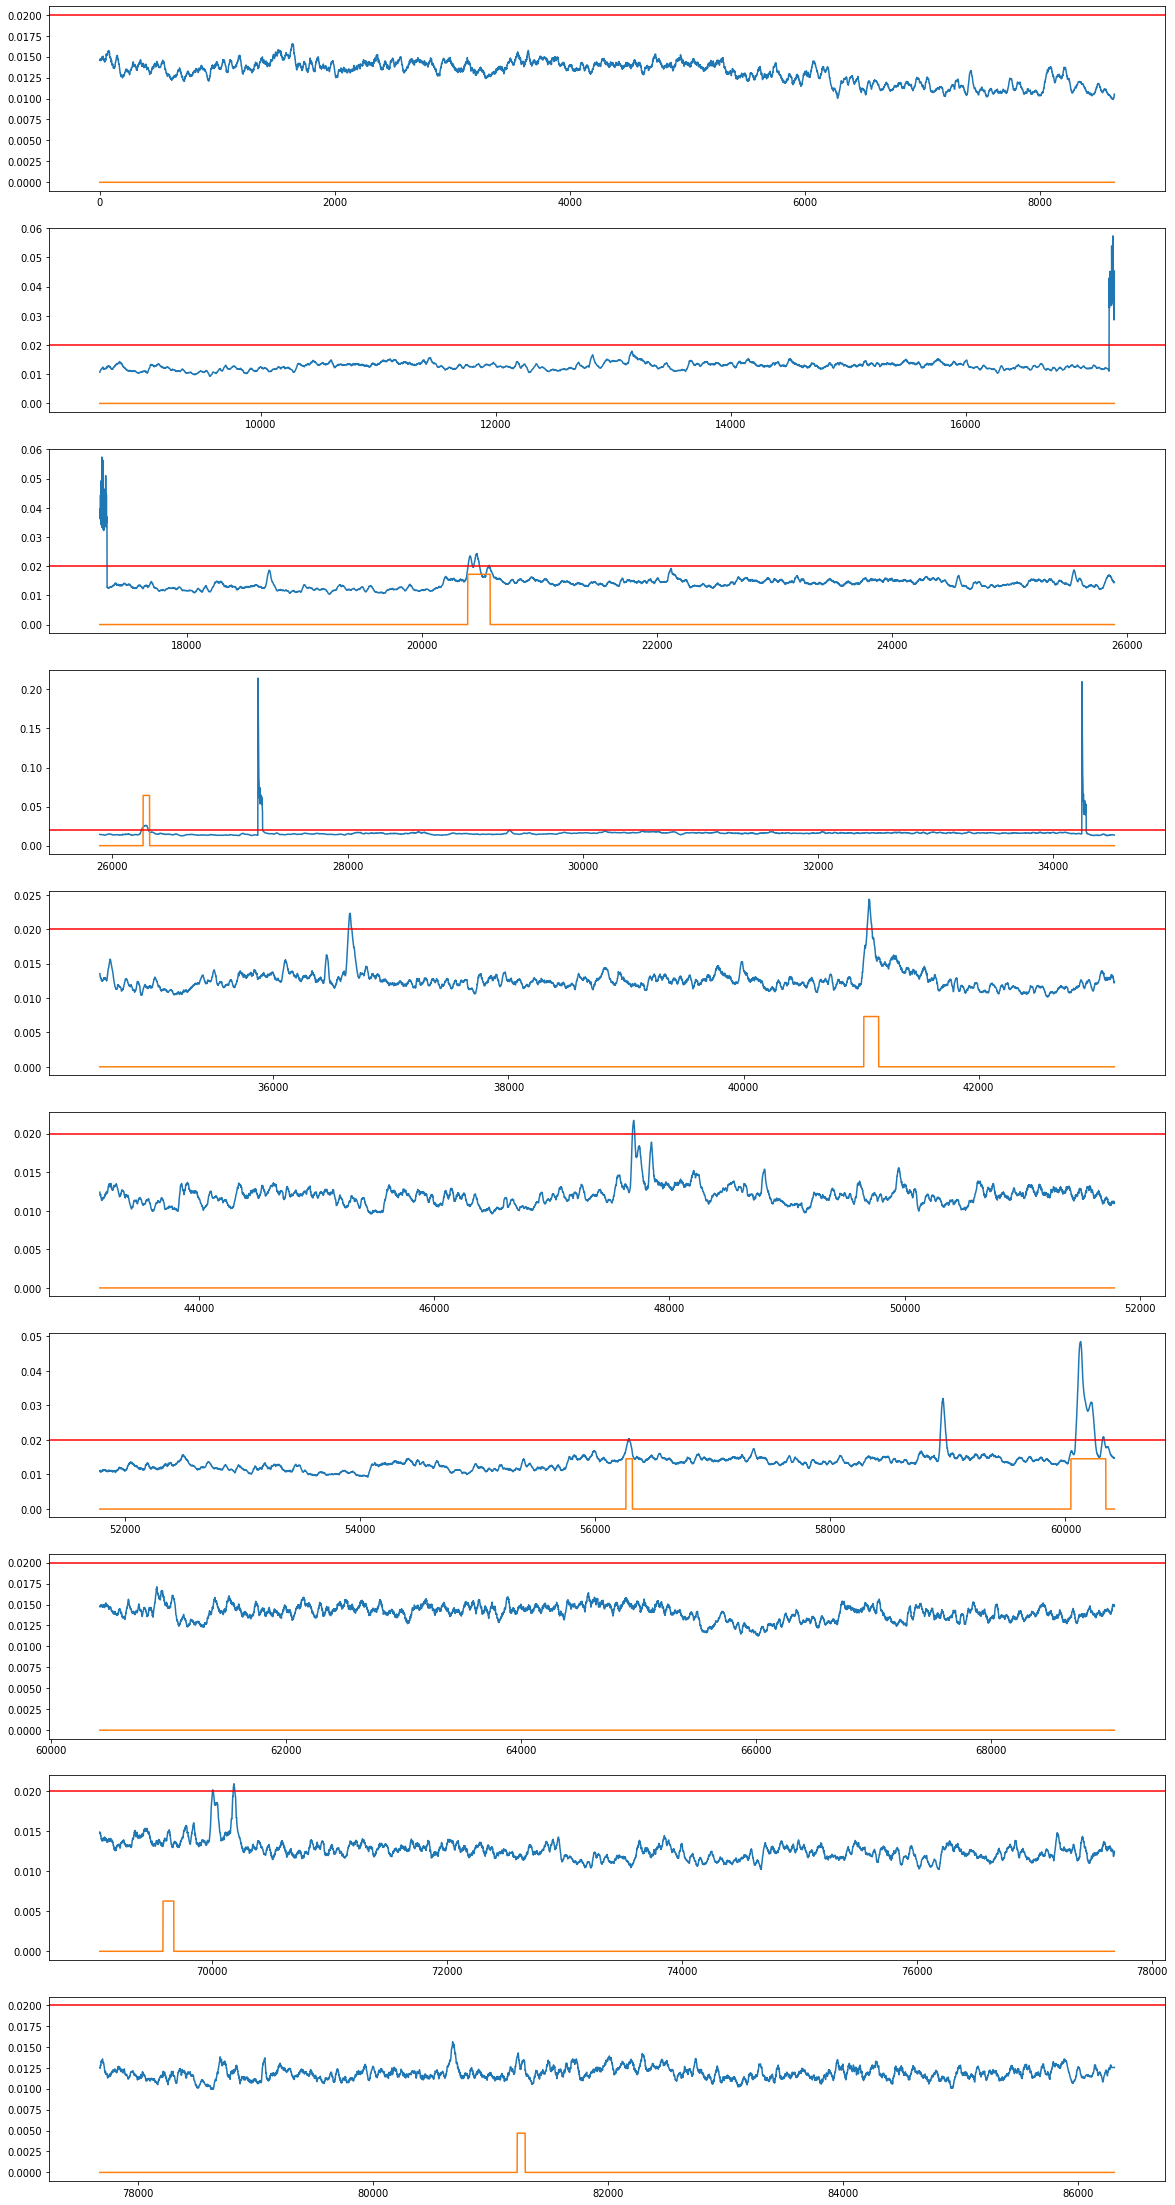

In [47]:
THRESHOLD = 0.02
check_graph(C_ANOMALY_SCORE, CHECK_ATT, piece=10, THRESHOLD=THRESHOLD)

In [48]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [49]:
LABELS = put_labels(C_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (86311,))

In [50]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [51]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [52]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 15.7 s, sys: 54 ms, total: 15.7 s
Wall time: 15.7 s


In [53]:
# 0.2
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.342 (TaP: 0.280, TaR: 0.441)
# of detected anomalies: 5
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7f089d37e110>, <TaPR_pkg.DataManage.Range.Range object at 0x7f089d37ed50>, <TaPR_pkg.DataManage.Range.Range object at 0x7f089d31e250>, <TaPR_pkg.DataManage.Range.Range object at 0x7f089d389f50>, <TaPR_pkg.DataManage.Range.Range object at 0x7f089d389810>]


# inference

In [54]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,50,11876,11.68213,28.03598,26979,28.46628,27.40174,0,1,50,27.66017,29.02832,1,298.73773,425.30319,3609,50,16454,1.06824,1,54718,980.07202,51.53651,5.6482,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12848,48.20861,1,0.75955,0.32135,0,335.30457,425.87881,6.93170,49.85962,719.92224,1,905,0,0,144,0.18680,9.57111,9972,1,268.33344,35.0,8.72313,236.93082,229.60286,27.68860,48.60640,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,50,12094,11.68213,28.03169,26981,28.46628,27.45389,0,1,50,27.66017,29.04358,1,303.80133,425.40543,3656,50,16713,1.08312,1,54719,979.20227,52.49024,5.4256,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12896,48.17810,1,0.68719,0.32211,0,340.47668,425.87881,6.93170,49.85962,720.02686,1,905,0,0,144,0.18680,9.60827,9972,1,273.29919,35.0,8.77705,237.31230,229.60286,27.68860,48.62812,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,50,12137,11.68213,28.03251,26983,28.46628,27.49862,0,1,50,27.66017,29.04358,1,309.17242,425.40543,3676,50,17022,1.09502,1,54718,980.07202,51.53651,5.1649,0,108.60724,2880,25.66094,0,0,...,97.24579,1,0,12944,48.16284,1,0.63293,0.31906,0,348.79559,425.87881,6.93170,49.85962,720.06177,1,905,0,0,128,0.18680,9.66742,9972,1,268.33344,35.0,8.93085,237.88448,222.65125,27.68860,48.66984,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,50,12187,11.68213,28.03251,26985,28.46628,27.56569,0,1,50,27.66017,29.05884,1,313.42230,425.50763,3719,50,17233,1.11219,1,54718,981.37659,51.72729,5.1649,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12984,48.13232,1,0.61487,0.32593,0,355.12512,425.87881,6.93170,49.85962,720.06177,1,905,0,0,112,0.18680,9.70509,9972,1,269.32672,35.0,8.91705,237.88448,227.61664,27.68097,48.64198,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,50,12198,11.68213,28.03081,26979,28.46628,27.56569,0,1,50,27.66017,29.05884,1,318.25092,424.94534,3725,50,17493,1.11219,1,54718,979.63727,52.10876,4.8932,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12696,48.11707,1,0.56064,0.32364,0,358.27185,425.87881,6.93170,49.85962,720.09613,1,906,0,0,96,0.18680,9.77965,9972,1,271.31296,35.0,8.91705,237.12160,230.59618,27.68097,48.59238,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,50,16228,18.91479,28.03953,26971,27.86075,28.35412,0,1,50,27.76649,28.95202,1,327.31122,460.57385,386,50,17966,1.04908,1,54718,1010.42865,61.45473,7.1499,0,108.24304,2880,25.68717,0,0,...,28.19976,1,0,4944,35.02502,1,36.85620,1.07132,0,318.08813,467.03854,26.76094,49.89013,719.98303,1,904,0,0,8384,0.06944,29.89865,9917,1,319.97427,35.0,14.31306,250.85446,981.37659,27.83356,49.44022,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,50,16108,19.18945,28.03953,26970,27.86075,28.47250,0,1,50,27.76649,2

In [55]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.455432,0.0,0.079812,0.479046,0.077046,0.434169,0.711769,0.0,0.0,0.0,0.399744,0.330391,0.498501,0.166913,0.536266,0.222300,0.0,0.0,0.0,0.699733,0.163355,0.0,0.251350,0.320025,0.585299,0.0,0.257818,0.346375,0.0,0.831111,0.410345,0.229845,0.389728,0.0,0.285038,0.0,0.057660,0.0,0.0,0.016555,...,0.993484,1.0,0.0,0.928902,0.881604,0.0,0.007099,0.011171,0.0,0.393798,0.318115,0.138634,0.267816,0.420875,1.0,0.784722,0.0,0.0,0.013832,0.910736,0.095711,0.344340,0.0,0.281687,1.0,0.087231,0.345953,0.068729,0.213449,0.233826,0.378726,0.095024,0.285153,0.068104,0.381526,0.0,0.393961,0.0,0.0,0.168791
1,0.471678,0.0,0.079812,0.499628,0.077046,0.429998,0.711769,0.0,0.0,0.0,0.410791,0.330391,0.401099,0.169598,0.536266,0.222988,0.0,0.0,0.0,0.699733,0.165362,0.0,0.268976,0.320597,0.592157,0.0,0.274666,0.362188,0.0,0.832458,0.407550,0.233744,0.354290,0.0,0.285038,0.0,0.057660,0.0,0.0,0.016555,...,0.993484,1.0,0.0,0.932055,0.879826,0.0,0.006401,0.011733,0.0,0.411441,0.318115,0.138634,0.267816,0.518035,1.0,0.784722,0.0,0.0,0.013832,0.910736,0.096049,0.344340,0.0,0.286465,1.0,0.087721,0.348326,0.068729,0.213449,0.234697,0.377826,0.099579,0.285153,0.069240,0.404094,0.0,0.393961,0.0,0.0,0.173300
2,0.459304,0.0,0.079812,0.482713,0.077046,0.410346,0.711769,0.0,0.0,0.0,0.413946,0.330391,0.410774,0.172502,0.536266,0.223634,0.0,0.0,0.0,0.699733,0.165543,0.0,0.289090,0.320648,0.595666,0.0,0.296103,0.376145,0.0,0.831245,0.410068,0.230232,0.309968,0.0,0.285038,0.0,0.057660,0.0,0.0,0.016080,...,0.993404,1.0,0.0,0.935463,0.878784,0.0,0.005820,0.009548,0.0,0.441153,0.318115,0.138634,0.267816,0.558917,1.0,0.784722,0.0,0.0,0.013099,0.910736,0.096612,0.344340,0.0,0.282161,1.0,0.089151,0.352068,0.066759,0.213449,0.236432,0.378191,0.103601,0.285153,0.068779,0.429462,0.0,0.393961,0.0,0.0,0.176731
3,0.458079,0.0,0.079812,0.478654,0.077046,0.408400,0.711769,0.0,0.0,0.0,0.416767,0.330391,0.411732,0.175448,0.536266,0.224574,0.0,0.0,0.0,0.699733,0.167548,0.0,0.305728,0.321219,0.602225,0.0,0.311816,0.395592,0.0,0.831124,0.414467,0.230656,0.305580,0.0,0.285038,0.0,0.057660,0.0,0.0,0.016372,...,0.993476,1.0,0.0,0.938402,0.876919,0.0,0.005590,0.014363,0.0,0.465474,0.318115,0.138634,0.267816,0.562964,1.0,0.784722,0.0,0.0,0.012294,0.910736,0.097007,0.344340,0.0,0.282681,1.0,0.089169,0.352439,0.067969,0.213350,0.235499,0.379124,0.109204,0.285153,0.068734,0.461282,0.0,0.393961,0.0,0.0,0.178719
4,0.380719,0.0,0.079812,0.515098,0.077046,0.367874,0.711769,0.0,0.0,0.0,0.417601,0.330391,0.373615,0.167766,0.536266,0.224668,0.0,0.0,0.0,0.699733,0.167748,0.0,0.324030,0.318164,0.603747,0.0,0.330130,0.397535,0.0,0.831112,0.409374,0.232242,0.262319,0.0,0.285038,0.0,0.057660,0.0,0.0,0.016604,...,0.993483,1.0,0.0,0.919967,0.875853,0.0,0.005049,0.013167,0.0,0.478530,0.318115,0.138634,0.267816,0.594960,1.0,0.790972,0.0,0.0,0.011482,0.910736,0.097718,0.344340,0.0,0.284625,1.0,0.089170,0.347777,0.068934,0.213340,0.233437,0.379218,0.109763,0.285153,0.066761,0.472272,0.0,0.393961,0.0,0.0,0.182832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.511523,0.0,0.017216,0.516825,0.147339,0.557125,0.711717,0.0,0.0,0.0,0.642342,0.536139,0.593564,0.155617,0.395860,0.236017,0.0,0.0,0.0,0.812424,0.152317,0.0,0.361328,0.537054,0.068753,0.0,0.366699,0.324469,0.0,0.831096,0.517503,0.274012,0.648670,0.0,0.272795,0.0,0.060821,0.0,0.0,0.093953,...,0.183679,1.0,0.0,0.359874,0.036115,0.0,0.386987,0.624489,0.0,0.329

In [56]:
boundary_check(TEST_DF)

(True, True, False)

In [57]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_TEST[0]

  0%|          | 0/274711 [00:00<?, ?it/s]

# of valid windows: 274533


{'answer': tensor([0.3561, 0.0000, 0.0798, 0.4972, 0.1030, 0.3958, 0.7118, 0.0000, 0.0000,
         0.0000, 0.3254, 0.4196, 0.4210, 0.3090, 0.5363, 0.2660, 0.0000, 0.0000,
         0.0000, 0.6997, 0.3088, 0.0000, 0.3013, 0.3171, 0.0066, 0.0000, 0.3031,
         0.3929, 0.0000, 0.8325, 0.4142, 0.2806, 0.4318, 0.0000, 0.2850, 0.0000,
         0.0577, 0.0000, 0.0000, 0.0186, 0.3402, 0.4977, 0.4490, 0.3920, 1.0000,
         1.0000, 0.9935, 1.0000, 0.0000, 0.0139, 0.7703, 0.0000, 0.6502, 0.0082,
         0.0000, 0.3030, 0.3181, 0.1386, 0.2675, 0.3540, 1.0000, 0.7910, 0.0000,
         0.0000, 0.5781, 0.9107, 0.0884, 0.3522, 0.0000, 0.3462, 1.0000, 0.1031,
         0.3477, 0.0773, 0.2591, 0.2876, 0.3868, 0.1053, 0.2852, 0.0794, 0.4622,
         0.0000, 0.3940, 0.0000, 0.0000, 0.0091]),
 'given': tensor([[0.4554, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1688],
         [0.4717, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1733],
         [0.4593, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1767],
      

In [58]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, model, args.batch_size)

CPU times: user 1min 47s, sys: 184 ms, total: 1min 48s
Wall time: 1min 47s


In [59]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
C_ANOMALY_SCORE = range_check(ANOMALY_SCORE, size=30)
print(C_ANOMALY_SCORE.shape)

(274533,)


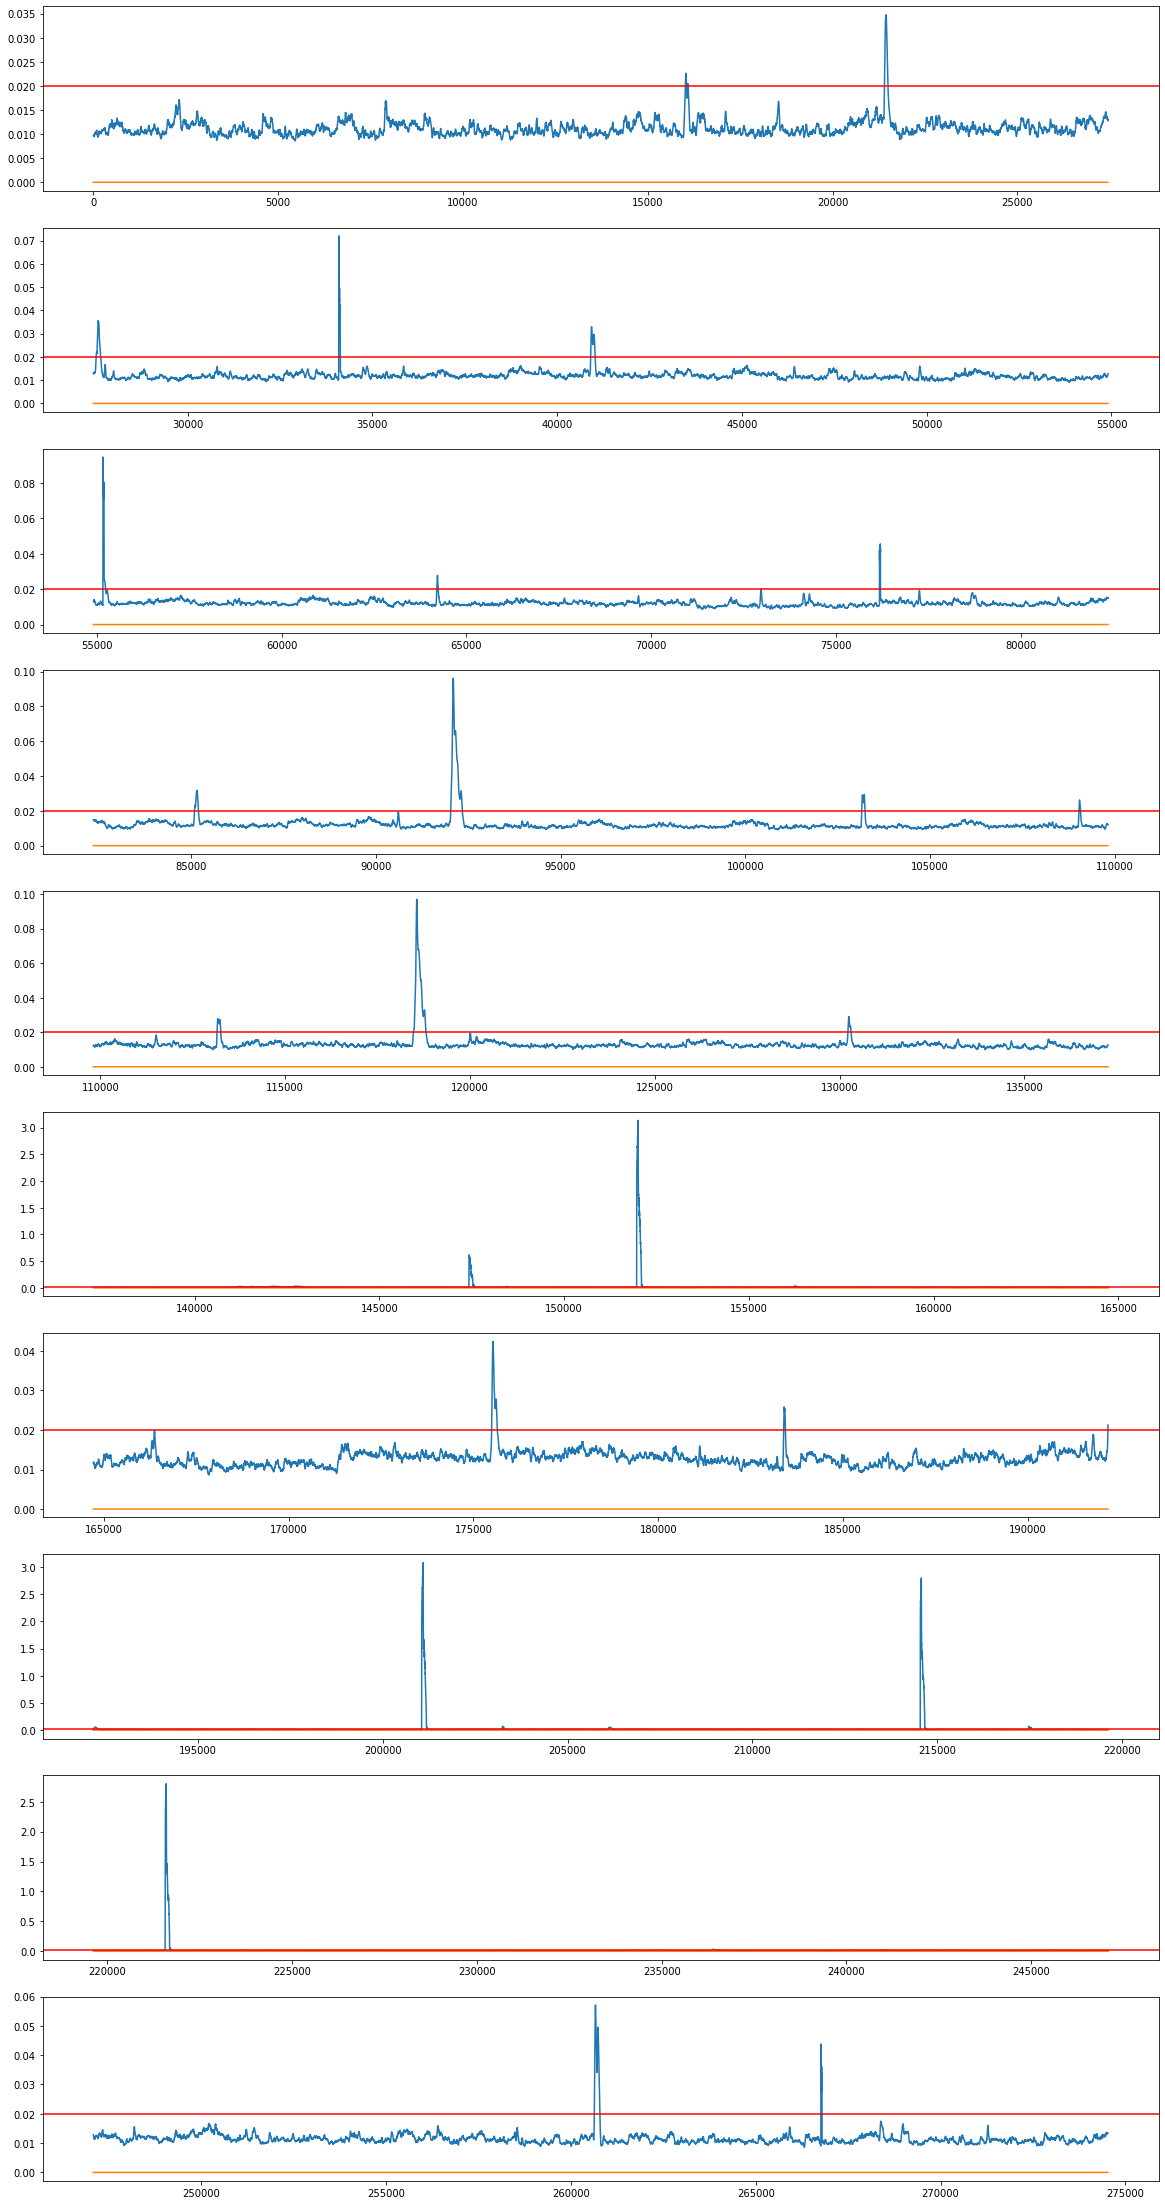

In [60]:
check_graph(C_ANOMALY_SCORE, CHECK_ATT, piece=10, THRESHOLD=THRESHOLD)

In [61]:
LABELS = put_labels(C_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (274533,))

In [64]:
submission = pd.read_csv('sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [65]:
submission.to_csv('transformer_baseline.csv', index=False)